In [1]:
from modules.models import Helmholtz2DPinn, create_dense_model
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from modules.utils import PrintLossCallback

2024-01-09 01:00:04.507956: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-09 01:00:04.542708: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-09 01:00:05.196810: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def rhs(xy):
    return (1 - np.pi**2 - (6*np.pi)**2) * tf.sin(np.pi * xy[:, 0:1]) * tf.sin(6 * np.pi * xy[:, 1:2])

def u(xy):
    return tf.sin(np.pi * xy[:, 0:1]) * tf.sin(6 * np.pi * xy[:, 1:2])

In [3]:
n_samples = 512

tx_samples = np.random.uniform(-1, 1, size=(n_samples, 2))

tx_bnd_bottom = np.concatenate([np.linspace(-1, 1, n_samples//4)[:, None], -np.ones(n_samples//4)[:, None]], axis=1)
tx_bnd_top = np.concatenate([np.linspace(-1, 1, n_samples//4)[:, None], np.ones(n_samples//4)[:, None]], axis=1)
tx_bnd_left = np.concatenate([-np.ones(n_samples//4)[:, None], np.linspace(-1, 1, n_samples//4)[:, None]], axis=1)
tx_bnd_right = np.concatenate([np.ones(n_samples//4)[:, None], np.linspace(-1, 1, n_samples//4)[:, None]], axis=1)
tx_bnd = np.concatenate([tx_bnd_bottom, tx_bnd_top, tx_bnd_left, tx_bnd_right], axis=0)

tx_samples = tf.convert_to_tensor(tx_samples, dtype=tf.float32)
tx_bnd = tf.convert_to_tensor(tx_bnd, dtype=tf.float32)
u_samples = u(tx_samples)
u_bnd = u(tx_bnd)
inputs = [tx_samples, tx_bnd]
outputs = [u_samples, rhs(tx_samples), u_bnd]

mean = tf.reduce_mean(tx_samples, axis=0)
std = tf.math.reduce_std(tx_samples, axis=0)

2024-01-09 01:00:06.334157: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-09 01:00:06.354784: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-09 01:00:06.354935: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

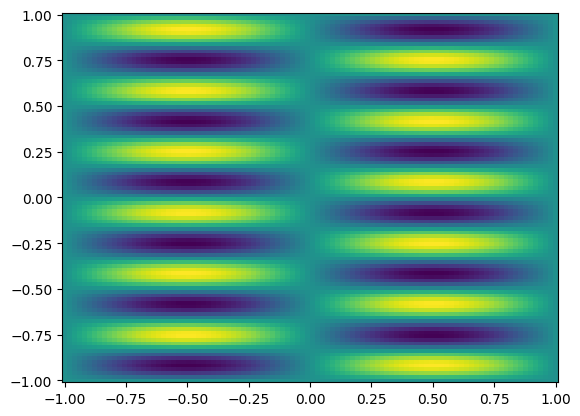

In [4]:
X, Y = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
XY = np.concatenate([X.flatten()[:, None], Y.flatten()[:, None]], axis=1)
plt.pcolormesh(X, Y, u(XY).numpy().reshape(X.shape))

In [9]:
class UniformSine(tf.keras.initializers.Initializer):
    def __init__(self, c=6.0, seed=42):
        self.c = c
        self.gen = tf.random.Generator.from_seed(seed)

    def __call__(self, shape, dtype=None):
        n_units = shape[0]
        return self.gen.uniform(shape, minval=-tf.math.sqrt(self.c / n_units), maxval=tf.math.sqrt(self.c / n_units),  dtype=dtype)

    def get_config(self):
        return {'c': self.c}

In [13]:
backbone = create_dense_model(layers= [tf.keras.layers.Normalization(mean=mean, variance=std**2)] + [512]*3, activation=tf.sin, \
    initializer=UniformSine(c=6.0, seed=10), n_inputs=2, n_outputs=1)
    # initializer=tf.keras.initializers.HeNormal(42), n_inputs=2, n_outputs=1)
backbone.layers[2].weights[0].assign(backbone.layers[2].weights[0] * 30)
pinn = Helmholtz2DPinn(backbone)

In [14]:
scheduler = tf.keras.optimizers.schedules.ExponentialDecay(1e-3, 1000, 0.95)
optimizer = tf.keras.optimizers.Adam(scheduler)
pinn.compile(optimizer=optimizer)

In [15]:
callbacks = [PrintLossCallback(1000)]
history = pinn.fit(inputs, outputs, epochs=50000, batch_size=1000, verbose=0, callbacks=callbacks)

2024-01-09 01:12:12.375856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,2]
	 [[{{node data}}]]
2024-01-09 01:12:12.764194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,2]
	 [[{{node data}}]]


Epoch: 000000, Lr: 191928736.00000, Lb: 0.71259, MAE: 0.80878, loss_total: 191928736.00000
Epoch: 001000, Lr: 17647.08594, Lb: 0.12915, MAE: 0.48212, loss_total: 17647.21484
Epoch: 002000, Lr: 25639.36719, Lb: 0.08984, MAE: 0.45893, loss_total: 25639.45703
Epoch: 003000, Lr: 13745.17578, Lb: 0.06141, MAE: 0.44142, loss_total: 13745.23730
Epoch: 004000, Lr: 12630.12891, Lb: 0.04325, MAE: 0.42980, loss_total: 12630.17188
Epoch: 005000, Lr: 8884.65723, Lb: 0.03119, MAE: 0.42281, loss_total: 8884.68848
Epoch: 006000, Lr: 4560.90674, Lb: 0.02280, MAE: 0.41752, loss_total: 4560.92969
Epoch: 007000, Lr: 2487.73120, Lb: 0.01696, MAE: 0.41391, loss_total: 2487.74805
Epoch: 008000, Lr: 2145.19214, Lb: 0.01275, MAE: 0.41139, loss_total: 2145.20483
Epoch: 009000, Lr: 1604.16479, Lb: 0.00970, MAE: 0.40932, loss_total: 1604.17444
Epoch: 010000, Lr: 1301.85620, Lb: 0.00735, MAE: 0.40778, loss_total: 1301.86353
